# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [44]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


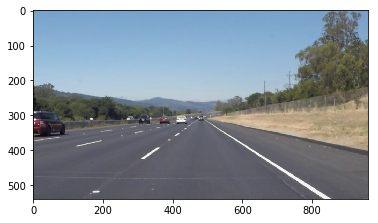

In [45]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [163]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slopes=[]
    for line in lines:
#         print(line)
        for x1,y1,x2,y2 in line:
            slopes.append((y2-y1)/(x2-x1))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    slopes = np.asarray(slopes)
    print(slopes)
    hist, bins = np.histogram(slopes, bins=5)
    print(np.argsort(hist))
    print("Hist",hist)
    print("Bins",bins)
    slope_1 = bins[np.argsort(hist)[-1:-2]]
    print(slope_1)
    slope_2 = bins[np.argsort(hist)[-2:-3]]
    print(slope_2)
    plt.show(plt.hist(slopes))

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

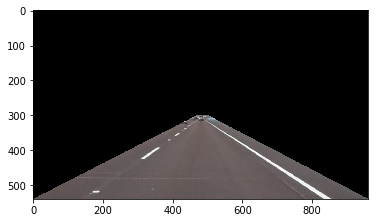

In [164]:
img_raw = cv2.imread('./test_images/solidWhiteRight.jpg')

left_bottom = [0,img_raw.shape[0]]
left_top = [470, 300]
right_top = [500, 300]
right_bottom = [img_raw.shape[1], img_raw.shape[0]]


vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
ROI = region_of_interest(img_raw, vertices)
plt.imshow(region_of_interest(img_raw, vertices))

[ 0.62466488  0.62365591  0.64902507 -0.7         0.65088757 -0.72516556
 -0.7         0.62568306  0.09333333 -0.06976744  0.65051903  0.01612903
 -0.03547297 -0.72425249 -0.69968051]
[1 3 2 0 4]
Hist [5 0 4 0 6]
Bins [-0.72516556 -0.44995494 -0.17474431  0.10046632  0.37567695  0.65088757]
[]
[]


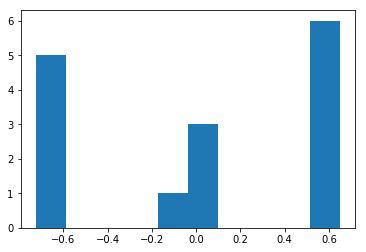

In [165]:
img = cv2.imread('./test_images/solidWhiteRight.jpg')
# img = img_raw[290:,:]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_canny = canny(gaussian_blur(img, gauss_kernel), low_threshold=70, high_threshold=80)

left_bottom = [0,img_raw.shape[0]]
left_top = [470, 300]
right_top = [500, 300]
right_bottom = [img_raw.shape[1], img_raw.shape[0]]

vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
img_roi = region_of_interest(img_canny, vertices)

overlay = hough_lines(img_roi, 1, (np.pi)/180, 20, 50, 500)
# plt.imshow(weighted_img(overlay, img_raw))

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [49]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [50]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
#     img = img[300:,:]
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = gaussian_blur(img, gauss_kernel)
#     img_canny = canny(img, low_threshold=150, high_threshold=155)
#     # hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
#     overlay = hough_lines(img_canny, 1, (np.pi)/180, 150, 50, 100)
#     plt.imshow(weighted_img(overlay, img))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_canny = canny(gaussian_blur(img, gauss_kernel), low_threshold=70, high_threshold=80)

    left_bottom = [0,img_raw.shape[0]]
    left_top = [470, 300]
    right_top = [500, 300]
    right_bottom = [img_raw.shape[1], img_raw.shape[0]]

    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    img_roi = region_of_interest(img_canny, vertices)

    overlay = hough_lines(img_roi, 1, (np.pi)/180, 20, 50, 500)
    return weighted_img(overlay, img)

In [53]:
## Tuning PArameters:
gauss_kernel = 5

Let's try the one with the solid white lane on the right first ...

In [54]:
clip1 = VideoFileClip('./test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

[[476 301 870 538]]
0.60152284264
[[478 304 674 427]]
0.627551020408
[[479 304 869 539]]
0.602564102564
[[205 513 477 301]]
-0.779411764706
[[474 304 848 538]]
0.625668449198
[[187 512 488 301]]
-0.700996677741
[[484 309 717 455]]
0.62660944206
[[471 303 847 538]]
0.625
[[482 304 698 434]]
0.601851851852
[[241 486 478 301]]
-0.7805907173
[[248 468 488 306]]
-0.675
[[267 454 489 304]]
-0.675675675676
[[203 514 464 303]]
-0.808429118774
[[200 515 470 304]]
-0.781481481481
[[424 325 503 309]]
-0.20253164557


In [55]:
white_output = './output_videos/solidWhiteRight.mp4'
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/solidWhiteRight.mp4
[MoviePy] Writing video ./output_videos/solidWhiteRight.mp4


  1%|          | 2/222 [00:00<00:13, 15.86it/s]

[[476 301 870 538]]
0.60152284264
[[478 304 674 427]]
0.627551020408
[[479 304 869 539]]
0.602564102564
[[205 513 477 301]]
-0.779411764706
[[474 304 848 538]]
0.625668449198
[[187 512 488 301]]
-0.700996677741
[[484 309 717 455]]
0.62660944206
[[471 303 847 538]]
0.625
[[482 304 698 434]]
0.601851851852
[[241 486 478 301]]
-0.7805907173
[[248 468 488 306]]
-0.675
[[267 454 489 304]]
-0.675675675676
[[203 514 464 303]]
-0.808429118774
[[200 515 470 304]]
-0.781481481481
[[424 325 503 309]]
-0.20253164557
[[479 305 868 538]]
0.598971722365
[[483 309 740 470]]
0.626459143969
[[477 302 756 470]]
0.602150537634
[[482 307 697 442]]
0.627906976744
[[157 533 488 301]]
-0.700906344411
[[193 522 473 304]]
-0.778571428571
[[470 304 846 538]]
0.622340425532
[[471 303 826 525]]
0.625352112676
[[250 466 489 304]]
-0.677824267782
[[347 396 485 300]]
-0.695652173913
[[150 538 502 301]]
-0.673295454545
[[170 539 440 321]]
-0.807407407407
[[190 524 451 313]]
-0.808429118774
[[249 480 467 304]]
-0.80733

  3%|▎         | 7/222 [00:00<00:12, 17.49it/s]

[[481 305 870 538]]
0.598971722365
[[474 304 849 538]]
0.624
[[479 305 707 448]]
0.627192982456
[[170 532 488 301]]
-0.72641509434
[[301 428 485 300]]
-0.695652173913
[[148 539 487 301]]
-0.702064896755
[[473 304 848 538]]
0.624
[[477 301 869 537]]
0.602040816327
[[169 539 468 305]]
-0.782608695652
[[316 429 480 301]]
-0.780487804878
[[458 306 523 312]]
0.0923076923077
[[448 313 499 315]]
0.0392156862745
[[169 538 451 310]]
-0.808510638298
[[479 304 870 538]]
0.598465473146
[[478 305 751 476]]
0.626373626374
[[477 301 763 473]]
0.601398601399
[[472 303 848 538]]
0.625
[[360 394 473 306]]
-0.778761061947
[[290 443 487 300]]
-0.725888324873
[[280 445 480 300]]
-0.725
[[280 442 489 301]]
-0.674641148325
[[463 307 847 538]]
0.6015625
[[482 307 851 528]]
0.59891598916
[[280 446 471 307]]
-0.727748691099
[[464 303 524 312]]
0.15
[[292 443 488 300]]
-0.729591836735
[[480 304 871 538]]
0.598465473146
[[474 303 824 522]]
0.625714285714
[[478 301 817 505]]
0.601769911504
[[251 463 483 300]]
-0.7

  5%|▍         | 10/222 [00:00<00:10, 19.38it/s]

[[481 304 871 538]]
0.6
[[474 303 779 494]]
0.626229508197
[[472 303 848 538]]
0.625
[[479 304 862 534]]
0.600522193211
[[162 525 484 300]]
-0.698757763975
[[181 524 489 300]]
-0.727272727273
[[179 524 487 301]]
-0.724025974026
[[478 305 595 378]]
0.623931623932
[[161 527 480 304]]
-0.699059561129
[[471 304 848 539]]
0.623342175066
[[423 324 505 317]]
-0.0853658536585
[[466 307 524 312]]
0.0862068965517
[[450 310 505 306]]
-0.0727272727273
[[479 306 865 538]]
0.60103626943
[[473 305 767 489]]
0.625850340136
[[471 305 844 538]]
0.624664879357
[[474 305 610 390]]
0.625
[[297 441 488 302]]
-0.727748691099
[[289 439 485 302]]
-0.698979591837
[[480 306 866 538]]
0.60103626943
[[478 310 843 538]]
0.624657534247
[[483 310 630 398]]
0.598639455782
[[327 411 481 303]]
-0.701298701299
[[450 312 511 307]]
-0.0819672131148
[[289 441 487 302]]
-0.70202020202
[[420 326 510 311]]
-0.166666666667
[[310 433 468 305]]
-0.810126582278
[[477 303 555 350]]
0.602564102564
[[456 307 522 313]]
0.0909090909091

  6%|▌         | 13/222 [00:00<00:09, 21.11it/s]


[[198 515 478 304]]
-0.753571428571
[[504 313 838 529]]
0.646706586826
[[448 315 539 320]]
0.0549450549451
[[480 306 824 520]]
0.622093023256
[[145 538 483 302]]
-0.698224852071
[[470 303 833 538]]
0.64738292011
[[478 306 621 399]]
0.65034965035
[[163 538 486 303]]
-0.727554179567
[[206 506 488 301]]
-0.72695035461
[[144 538 481 302]]
-0.700296735905
[[472 303 834 538]]
0.649171270718
[[164 538 490 302]]


  7%|▋         | 15/222 [00:00<00:10, 19.11it/s]

-0.723926380368
[[477 302 856 538]]
0.622691292876
[[477 303 855 539]]
0.624338624339
[[468 302 833 539]]
0.649315068493
[[145 539 482 303]]
-0.700296735905
[[468 303 529 315]]
0.196721311475
[[480 304 857 539]]
0.623342175066
[[470 301 835 538]]
0.649315068493
[[141 538 480 301]]
-0.699115044248
[[478 304 645 413]]
0.652694610778
[[186 519 487 300]]
-0.727574750831
[[479 304 816 514]]
0.623145400593
[[477 300 856 537]]
0.625329815303
[[161 538 488 300]]
-0.727828746177
[[142 539 483 300]]
-0.700879765396
[[477 301 857 538]]
0.623684210526
[[257 466 474 308]]
-0.728110599078
[[467 302 661 424]]
0.628865979381
[[486 309 603 385]]
0.649572649573
[[464 306 828 534]]
0.626373626374
[[422 324 502 309]]
-0.1875
[[480 302 858 538]]
0.624338624339
[[541 343 738 475]]
0.670050761421
[[473 303 836 538]]
0.64738292011
[[158 537 478 304]]
-0.728125
[[479 302 858 539]]
0.625329815303
[[157 538 481 303]]
-0.725308641975
[[138 539 457 307]]
-0.727272727273
[[487 308 567 361]]
0.6625
[[147 533 476 302

  9%|▊         | 19/222 [00:00<00:11, 18.19it/s]

-0.697452229299
[[156 539 477 306]]
-0.725856697819
[[159 525 477 303]]
-0.698113207547
[[169 527 474 306]]
-0.724590163934
[[137 538 471 304]]
-0.700598802395
[[480 302 859 539]]
0.625329815303
[[450 310 513 307]]
-0.047619047619
[[479 302 858 538]]
0.622691292876
[[472 300 744 477]]
0.650735294118
[[471 301 836 538]]
0.649315068493
[[497 312 852 534]]
0.625352112676
[[482 305 642 409]]
0.65
[[350 390 486 302]]
-0.647058823529
[[363 389 471 305]]
-0.777777777778
[[350 391 488 305]]
-0.623188405797
[[357 392 470 304]]
-0.778761061947
[[466 304 785 504]]
0.626959247649
[[456 307 513 308]]
0.0175438596491
[[467 304 736 472]]
0.624535315985
[[475 301 687 439]]
0.650943396226
[[493 311 857 539]]
0.626373626374
[[293 439 482 302]]
-0.724867724868
[[480 304 855 538]]
0.624
[[478 300 764 493]]
0.674825174825
[[480 300 834 538]]
0.672316384181
[[348 401 475 302]]
-0.779527559055
[[482 304 644 413]]
0.672839506173
[[269 459 476 303]]
-0.753623188406
[[251 462 490 300]]
-0.677824267782
[[493 310

 10%|█         | 23/222 [00:01<00:09, 20.67it/s]

-0.698979591837
[[475 304 647 416]]
0.651162790698
[[290 437 482 303]]
-0.697916666667
[[291 439 481 306]]
-0.7
[[462 305 531 316]]
0.159420289855
[[465 309 832 538]]
0.623978201635
[[422 326 514 312]]
-0.152173913043
[[482 306 854 538]]
0.623655913978
[[472 303 823 531]]
0.649572649573
[[468 302 832 538]]
0.648351648352
[[264 454 487 303]]
-0.677130044843
[[264 455 493 301]]
-0.672489082969
[[480 306 853 539]]
0.624664879357
[[474 303 643 413]]
0.650887573964
[[277 456 481 303]]
-0.75
[[301 439 483 302]]
-0.752747252747
[[266 456 495 302]]
-0.672489082969
[[462 304 529 315]]
0.164179104478
[[422 326 505 312]]
-0.168674698795
[[264 456 494 301]]
-0.673913043478


 12%|█▏        | 26/222 [00:01<00:09, 21.21it/s]

[[480 305 854 538]]
0.622994652406
[[473 302 695 447]]
0.653153153153
[[468 301 833 538]]
0.649315068493
[[231 476 489 302]]
-0.674418604651
[[270 461 474 302]]
-0.779411764706
[[472 304 831 537]]
0.649025069638
[[475 303 632 405]]
0.649681528662
[[482 305 850 535]]
0.625
[[232 476 493 300]]
-0.674329501916
[[244 479 479 302]]
-0.753191489362
[[475 302 854 539]]
0.625329815303
[[263 466 481 302]]
-0.752293577982
[[232 479 497 301]]
-0.671698113208
[[232 478 495 301]]
-0.673003802281
[[246 478 480 302]]
-0.752136752137
[[454 310 514 311]]
0.0166666666667
[[480 304 855 538]]
0.624
[[473 302 699 449]]
0.650442477876
[[468 301 834 538]]
0.647540983607
[[200 510 488 301]]
-0.725694444444
[[187 508 477 305]]
-0.7
[[476 302 855 539]]
0.625329815303
[[186 509 484 301]]
-0.697986577181
[[188 509 485 301]]
-0.700336700337
[[205 508 489 302]]
-0.725352112676
[[464 303 717 461]]
0.624505928854
[[186 507 480 301]]
-0.700680272109
[[488 308 707 445]]
0.625570776256
[[452 310 518 311]]
0.015151515151

 14%|█▍        | 32/222 [00:01<00:08, 22.78it/s]

[[474 301 855 539]]
0.62467191601
[[473 303 790 509]]
0.649842271293
[[474 302 537 343]]
0.650793650794
[[467 308 825 532]]
0.625698324022
[[172 527 483 301]]
-0.726688102894
[[476 301 855 538]]
0.625329815303
[[164 538 490 301]]
-0.726993865031
[[174 528 476 309]]
-0.725165562914
[[468 310 834 538]]
0.622950819672
[[488 308 856 538]]
0.625
[[483 310 831 536]]
0.649425287356
[[153 533 485 301]]
-0.698795180723
[[142 539 496 300]]
-0.675141242938
[[464 303 525 313]]
0.16393442623
[[473 303 835 538]]
0.649171270718
[[475 301 856 539]]
0.62467191601
[[474 302 685 439]]
0.649289099526
[[477 301 857 538]]
0.623684210526
[[280 444 484 301]]
-0.700980392157
[[299 441 485 301]]
-0.752688172043
[[470 302 835 539]]
0.649315068493
[[281 444 450 325]]
-0.704142011834
[[285 439 474 307]]
-0.698412698413
[[294 441 487 301]]
-0.725388601036
[[457 313 507 315]]
0.04
[[455 309 506 310]]
0.0196078431373
[[288 442 490 301]]
-0.69801980198
[[290 442 492 301]]
-0.69801980198
[[482 309 834 538]]
0.650568181

 16%|█▌        | 35/222 [00:01<00:08, 22.24it/s]

[[475 301 830 522]]
0.622535211268
[[473 303 836 538]]
0.64738292011
[[476 300 858 538]]
0.623036649215
[[474 302 837 538]]
0.650137741047
[[292 436 475 308]]
-0.699453551913
[[300 437 489 300]]
-0.724867724868
[[292 434 484 300]]
-0.697916666667
[[474 301 543 346]]
0.652173913043
[[303 436 491 300]]
-0.723404255319
[[299 437 482 304]]
-0.726775956284
[[491 308 857 537]]
0.625683060109
[[292 435 485 300]]
-0.699481865285
[[497 315 694 438]]
0.624365482234
[[429 323 510 305]]
-0.222222222222
[[460 305 522 311]]
0.0967741935484
[[475 302 855 539]]
0.623684210526
[[473 304 834 539]]
0.650969529086
[[475 301 855 538]]
0.623684210526
[[267 453 492 301]]
-0.675555555556
[[474 303 833 537]]
0.651810584958
[[474 302 726 459]]
0.623015873016
[[278 455 489 302]]
-0.725118483412
[[270 455 478 304]]
-0.725961538462
[[477 301 853 536]]
0.625
[[474 304 545 348]]
0.619718309859
[[275 455 476 309]]
-0.726368159204
[[305 426 499 300]]
-0.649484536082
[[430 324 511 306]]
-0.222222222222
[[272 455 484 30

 17%|█▋        | 38/222 [00:01<00:07, 23.83it/s]

[[483 308 854 539]]
0.622641509434
[[166 538 491 302]]
-0.726153846154
[[468 301 833 538]]
0.649315068493
[[147 538 484 302]]
-0.700296735905
[[186 523 490 302]]
-0.726973684211
[[484 309 574 368]]
0.655555555556
[[147 539 481 305]]
-0.700598802395
[[479 303 551 348]]
0.625
[[479 304 854 538]]
0.624
[[201 499 482 302]]
-0.701067615658
[[290 446 488 302]]
-0.727272727273
[[289 445 488 301]]
-0.723618090452
[[469 304 622 400]]
0.627450980392
[[470 303 833 539]]
0.650137741047
[[167 539 494 301]]
-0.727828746177
[[146 538 484 301]]
-0.701183431953
[[464 303 525 313]]
0.16393442623
[[420 325 506 319]]
-0.0697674418605
[[480 304 855 538]]
0.624
[[483 307 854 539]]
0.625336927224
[[470 303 833 539]]
0.650137741047
[[469 301 834 538]]


 18%|█▊        | 41/222 [00:01<00:07, 22.78it/s]

0.649315068493
[[145 539 484 301]]
-0.702064896755
[[166 539 481 301]]
-0.755555555556
[[256 464 489 301]]
-0.699570815451
[[484 309 581 372]]
0.649484536082
[[479 302 551 347]]
0.625
[[170 536 484 300]]
-0.751592356688
[[165 538 480 301]]
-0.752380952381
[[344 406 487 303]]
-0.72027972028
[[422 324 511 310]]
-0.157303370787
[[505 319 557 351]]
0.615384615385
[[257 472 471 305]]
-0.780373831776
[[468 306 715 461]]
0.627530364372
[[482 310 593 380]]
0.630630630631
[[479 304 854 539]]
0.626666666667
[[470 302 833 538]]
0.650137741047
[[164 539 481 300]]
-0.753943217666
[[483 306 855 538]]
0.623655913978
[[476 305 716 461]]
0.65
[[143 538 496 300]]
-0.674220963173
[[479 302 576 363]]
0.628865979381
[[500 318 579 370]]
0.658227848101
[[175 531 482 300]]
-0.752442996743
[[164 538 468 309]]
-0.753289473684
[[143 539 497 300]]
-0.675141242938
[[371 380 490 300]]
-0.672268907563
[[142 538 495 300]]
-0.674220963173
[[422 324 504 310]]
-0.170731707317
[[324 413 491 300]]
-0.676646706587
[[460 30

 20%|█▉        | 44/222 [00:02<00:08, 21.95it/s]

[[483 307 855 539]]
0.623655913978
[[482 305 855 538]]
0.624664879357
[[468 302 833 539]]
0.649315068493
[[469 301 833 538]]
0.651098901099
[[484 302 650 418]]
0.698795180723
[[222 482 479 302]]
-0.700389105058
[[483 300 611 386]]
0.671875
[[330 407 486 301]]
-0.679487179487
[[489 305 662 426]]
0.699421965318
[[477 304 822 519]]
0.623188405797
[[242 481 480 302]]
-0.752100840336
[[241 481 472 307]]
-0.753246753247
[[487 300 585 374]]
0.755102040816
[[482 308 694 446]]
0.650943396226
[[429 322 506 305]]
-0.220779220779
[[481 303 618 389]]
0.627737226277
[[482 306 854 538]]
0.623655913978
[[481 303 831 539]]
0.674285714286
[[344 405 472 305]]
-0.78125
[[173 518 480 303]]
-0.700325732899
[[177 518 471 305]]
-0.724489795918
[[497 312 584 367]]
0.632183908046
[[198 514 483 300]]
-0.750877192982
[[483 308 853 539]]
0.624324324324
[[491 308 832 538]]
0.674486803519
[[385 366 489 301]]
-0.625
[[501 318 744 481]]
0.670781893004
[[485 302 594 375]]
0.669724770642
[[424 323 515 309]]
-0.153846153

 21%|██        | 47/222 [00:02<00:08, 21.03it/s]


0.672597864769
[[486 303 719 454]]
0.648068669528
[[270 448 476 304]]
-0.699029126214
[[486 300 850 536]]
0.648351648352
[[493 309 832 538]]
0.675516224189
[[486 302 789 498]]
0.646864686469
[[281 450 488 300]]
-0.724637681159
[[295 430 465 311]]
-0.7
[[270 449 474 306]]
-0.700980392157
[[277 451 483 302]]
-0.723300970874
[[489 301 855 539]]
0.650273224044
[[275 451 474 307]]
-0.723618090452
[[454 308 517 309]]
0.015873015873
[[582 366 787 509]]
0.69756097561
[[505 316 568 358]]
0.666666666667
[[470 300 582 370]]
0.625
[[280 450 476 308]]
-0.724489795918


 23%|██▎       | 50/222 [00:02<00:08, 19.80it/s]

[[477 300 831 539]]
0.675141242938
[[481 300 742 469]]
0.647509578544
[[480 303 753 487]]
0.673992673993
[[252 472 474 305]]
-0.752252252252
[[483 303 831 538]]
0.675287356322
[[240 469 468 309]]
-0.701754385965
[[486 301 853 539]]
0.648501362398
[[497 312 577 364]]
0.65
[[246 465 489 301]]
-0.674897119342
[[495 302 766 484]]
0.671586715867
[[482 300 576 363]]
0.670212765957
[[251 472 456 318]]
-0.751219512195
[[478 303 538 343]]
0.666666666667
[[500 300 853 538]]
0.674220963173
[[367 379 489 300]]
-0.647540983607
[[454 308 515 309]]
0.016393442623
[[489 304 616 389]]
0.669291338583
[[502 307 741 468]]
0.673640167364
[[240 471 469 305]]
-0.724890829694
[[479 304 854 538]]
0.624
[[198 499 483 300]]
-0.698245614035
[[477 300 831 539]]
0.675141242938
[[481 304 772 500]]
0.6735395189
[[215 500 469 302]]
-0.779527559055
[[476 300 635 400]]
0.62893081761
[[482 307 853 539]]
0.625336927224
[[250 474 465 306]]
-0.781395348837
[[200 501 488 300]]
-0.697916666667
[[459 309 518 310]]
0.0169491525

 24%|██▍       | 53/222 [00:02<00:09, 17.14it/s]

[[476 300 831 539]]
0.67323943662
[[480 304 852 537]]
0.626344086022
[[137 538 478 300]]
-0.697947214076
[[482 303 641 403]]
0.62893081761
[[158 539 470 303]]
-0.75641025641
[[471 301 852 539]]
0.62467191601
[[228 481 487 300]]
-0.698841698842
[[482 307 636 400]]
0.603896103896
[[321 409 484 300]]
-0.668711656442
[[519 330 765 495]]
0.670731707317
[[227 481 486 300]]
-0.698841698842
[[177 525 471 304]]
-0.751700680272
[[457 308 518 310]]
0.0327868852459
[[479 300 547 345]]
0.661764705882
[[482 300 783 495]]
0.647840531561
[[501 307 831 538]]
0.7
[[230 481 489 300]]
-0.698841698842
[[479 313 853 538]]
0.601604278075
[[374 373 475 305]]
-0.673267326733
[[476 301 744 469]]
0.626865671642
[[477 300 831 539]]
0.675141242938
[[476 300 811 526]]
0.674626865672
[[135 538 488 300]]
-0.674220963173
[[478 304 853 538]]
0.624
[[365 386 479 300]]
-0.754385964912
[[497 313 672 423]]
0.628571428571
[[477 304 852 538]]
0.624
[[156 538 471 301]]
-0.752380952381
[[314 423 478 300]]
-0.75
[[420 347 480 3

 25%|██▍       | 55/222 [00:02<00:09, 17.39it/s]

0.675141242938
[[476 301 775 502]]
0.672240802676
[[479 304 850 536]]
0.625336927224
[[475 303 852 538]]
0.623342175066
[[253 456 478 304]]
-0.675555555556
[[265 455 486 300]]
-0.701357466063
[[476 306 603 380]]
0.582677165354
[[479 300 830 537]]
0.675213675214
[[254 454 482 300]]
-0.675438596491
[[468 306 586 369]]
0.533898305085
[[267 455 488 300]]
-0.701357466063
[[457 307 520 311]]
0.0634920634921
[[481 300 569 359]]
0.670454545455
[[262 455 488 302]]
-0.676991150442
[[253 457 487 300]]
-0.67094017094
[[423 324 510 306]]
-0.206896551724
[[475 302 848 535]]
0.624664879357
[[472 302 626 402]]
0.649350649351
[[479 305 852 538]]
0.624664879357
[[472 303 731 471]]
0.648648648649
[[474 305 795 514]]
0.651090342679
[[475 307 829 537]]
0.649717514124
[[235 480 482 301]]
-0.724696356275
[[476 301 594 375]]
0.627118644068
[[322 409 488 301]]
-0.650602409639
[[221 482 488 302]]
-0.674157303371
[[457 307 520 312]]
0.0793650793651
[[222 482 480 301]]
-0.701550387597
[[468 304 830 539]]
0.649171

 26%|██▌       | 57/222 [00:02<00:12, 12.84it/s]

[[480 306 852 538]]
0.623655913978
[[475 307 806 522]]
0.649546827795
[[170 513 483 302]]
-0.674121405751
[[476 302 811 512]]
0.626865671642
[[472 303 717 463]]
0.65306122449
[[187 512 487 302]]
-0.7
[[478 306 604 388]]
0.650793650794
[[470 305 829 538]]
0.649025069638
[[186 512 486 302]]
-0.7
[[631 401 850 538]]
0.625570776256
[[462 309 526 314]]
0.078125
[[350 390 480 302]]
-0.676923076923
[[182 513 460 318]]
-0.701438848921
[[339 398 488 305]]
-0.624161073826
[[458 318 515 312]]
-0.105263157895
[[480 307 851 538]]
0.622641509434
[[476 303 736 478]]
0.673076923077
[[286 435 485 301]]
-0.673366834171
[[474 304 850 539]]
0.625
[[478 303 828 539]]
0.674285714286
[[294 437 488 301]]
-0.701030927835
[[537 345 693 450]]
0.673076923077
[[296 437 488 303]]
-0.697916666667
[[487 313 541 349]]
0.666666666667
[[457 311 523 314]]
0.0454545454545
[[286 437 487 301]]
-0.676616915423
[[286 436 477 303]]
-0.696335078534
[[485 302 754 490]]
0.698884758364
[[422 326 511 308]]
-0.202247191011


 27%|██▋       | 59/222 [00:03<00:13, 12.18it/s]

[[476 303 827 539]]
0.672364672365
[[474 304 849 538]]
0.624
[[472 304 621 394]]
0.604026845638
[[260 452 481 303]]
-0.674208144796
[[260 453 475 308]]
-0.674418604651
[[270 454 488 302]]
-0.697247706422
[[479 306 750 488]]
0.671586715867
[[477 302 828 538]]
0.672364672365
[[267 455 487 301]]
-0.7
[[471 305 668 424]]
0.604060913706
[[272 454 485 305]]
-0.699530516432
[[464 304 632 401]]
0.577380952381
[[422 326 514 307]]
-0.20652173913
[[457 310 519 313]]
0.0483870967742
[[476 303 826 539]]
0.674285714286
[[479 302 777 495]]
0.647651006711
[[474 303 767 500]]
0.672354948805
[[226 475 486 300]]
-0.673076923077
[[239 476 489 301]]
-0.7
[[237 476 488 301]]
-0.697211155378
[[476 302 592 377]]
0.646551724138
[[226 474 481 302]]
-0.674509803922
[[482 302 848 539]]
0.647540983607
[[474 304 549 354]]
0.666666666667
[[477 302 689 439]]
0.646226415094
[[454 308 520 313]]
0.0757575757576
[[236 476 488 300]]
-0.698412698413
[[502 310 771 491]]
0.672862453532
[[464 307 848 538]]
0.6015625
[[425 325

 28%|██▊       | 63/222 [00:03<00:12, 12.64it/s]


[[192 497 481 302]]
-0.674740484429
[[478 306 823 538]]
0.672463768116
[[132 538 483 302]]
-0.672364672365
[[477 302 685 437]]
0.649038461538
[[480 303 844 539]]
0.648351648352
[[151 538 490 301]]
-0.699115044248
[[475 303 824 538]]
0.67335243553
[[131 538 479 303]]
-0.675287356322
[[479 307 823 539]]
0.674418604651
[[132 539 487 300]]
-0.67323943662
[[209 496 488 300]]
-0.702508960573
[[489 311 608 388]]
0.647058823529
[[505 309 845 538]]
0.673529411765
[[280 444 459 319]]
-0.698324022346
[[456 310 529 315]]
0.0684931506849
[[504 310 831 530]]
0.672782874618
[[474 303 823 538]]
0.67335243553
[[480 303 844 539]]
0.648351648352
[[151 539 477 302]]
-0.726993865031
[[478 303 753 481]]
0.647272727273
[[132 538 481 302]]
-0.676217765043
[[477 306 820 537]]
0.673469387755
[[164 530 470 308]]
-0.725490196078
[[481 306 612 391]]
0.648854961832
[[377 378 481 303]]
-0.721153846154
[[195 494 490 302]]
-0.650847457627
[[132 539 483 302]]
-0.675213675214
[[493 317 544 352]]
0.686274509804
[[452 30

 31%|███       | 68/222 [00:03<00:10, 15.30it/s]

[[476 306 821 538]]
0.672463768116
[[480 303 842 538]]
0.649171270718
[[475 302 669 428]]
0.649484536082
[[475 304 820 537]]
0.675362318841
[[476 302 695 444]]
0.648401826484
[[347 391 492 301]]
-0.620689655172
[[356 393 483 301]]
-0.724409448819
[[353 394 481 301]]
-0.7265625
[[485 302 716 457]]
0.670995670996
[[480 309 821 539]]
0.674486803519
[[278 436 492 302]]
-0.626168224299
[[470 307 529 315]]
0.135593220339
[[411 349 490 300]]
-0.620253164557
[[427 325 514 307]]
-0.206896551724
[[475 303 824 538]]
0.67335243553
[[475 301 704 449]]
0.646288209607
[[479 301 845 539]]
0.650273224044
[[263 455 483 301]]
-0.7
[[250 458 475 306]]
-0.675555555556
[[248 457 482 300]]
-0.67094017094
[[348 397 487 300]]
-0.697841726619
[[476 305 823 539]]
0.674351585014
[[487 302 733 467]]
0.670731707317
[[450 310 515 311]]
0.0153846153846
[[493 301 712 454]]
0.698630136986
[[248 458 490 301]]
-0.648760330579
[[365 385 470 303]]
-0.780952380952
[[483 300 701 447]]
0.674311926606
[[422 324 509 307]]
-0.19

 32%|███▏      | 72/222 [00:03<00:09, 16.40it/s]


0.673202614379
[[479 301 846 539]]
0.648501362398
[[316 419 485 301]]
-0.698224852071
[[183 510 483 300]]
-0.7
[[334 399 491 301]]
-0.624203821656
[[457 308 525 313]]
0.0735294117647
[[315 419 478 301]]
-0.723926380368
[[422 324 512 307]]
-0.188888888889
[[475 302 602 384]]
0.645669291339
[[494 300 847 538]]
0.674220963173
[[174 510 469 304]]
-0.698305084746
[[477 305 822 538]]
0.675362318841
[[475 302 704 450]]
0.646288209607
[[475 301 809 517]]
0.646706586826
[[287 433 483 301]]
-0.673469387755
[[478 301 844 539]]
0.650273224044
[[287 431 481 301]]
-0.670103092784
[[310 424 486 301]]
-0.698863636364
[[296 433 485 301]]
-0.698412698413
[[480 308 822 539]]
0.675438596491
[[422 324 512 307]]
-0.188888888889
[[428 324 510 311]]
-0.158536585366
[[477 305 822 538]]
0.675362318841
[[477 301 844 539]]
0.648501362398
[[475 301 709 453]]
0.649572649573
[[261 447 485 301]]
-0.651785714286
[[273 449 478 305]]
-0.70243902439
[[261 449 482 300]]
-0.674208144796
[[476 305 822 539]]
0.676300578035


 34%|███▍      | 76/222 [00:04<00:09, 15.36it/s]

[[474 304 821 538]]
0.674351585014
[[481 305 831 532]]
0.648571428571
[[132 532 488 301]]
-0.648876404494
[[480 309 820 538]]
0.673529411765
[[476 301 842 538]]
0.647540983607
[[127 536 489 301]]
-0.649171270718
[[474 302 664 425]]
0.647368421053
[[143 538 480 302]]
-0.700296735905
[[144 539 485 301]]
-0.697947214076
[[343 393 460 317]]
-0.649572649573
[[142 538 481 301]]
-0.699115044248
[[146 537 475 307]]
-0.699088145897
[[454 310 519 312]]
0.0307692307692
[[474 304 820 538]]
0.676300578035
[[123 538 488 301]]
-0.649315068493
[[475 301 841 539]]
0.650273224044
[[475 302 765 490]]
0.648275862069
[[143 539 482 301]]
-0.702064896755
[[480 310 819 538]]
0.672566371681
[[474 303 586 379]]
0.678571428571
[[131 532 487 301]]
-0.648876404494
[[247 459 490 301]]
-0.650205761317
[[476 301 841 538]]
0.649315068493
[[142 538 481 301]]
-0.699115044248
[[246 459 480 301]]
-0.675213675214
[[251 458 494 300]]
-0.650205761317
[[451 310 520 312]]
0.0289855072464
[[423 324 512 307]]
-0.191011235955
[[4

 36%|███▋      | 81/222 [00:04<00:07, 17.76it/s]

[[477 304 840 539]]
0.64738292011
[[479 309 819 538]]
0.673529411765
[[472 302 631 410]]
0.679245283019
[[475 301 840 538]]
0.649315068493
[[138 539 479 300]]
-0.700879765396
[[171 513 487 300]]
-0.674050632911
[[119 538 486 300]]
-0.648501362398
[[473 302 743 477]]
0.648148148148
[[299 420 475 305]]
-0.653409090909
[[474 301 839 538]]
0.649315068493
[[307 422 488 300]]
-0.674033149171
[[468 304 647 421]]
0.653631284916
[[470 304 818 539]]
0.675287356322
[[460 305 524 312]]
0.109375
[[427 323 512 306]]
-0.2
[[119 539 461 317]]
-0.649122807018
[[478 304 839 539]]
0.650969529086
[[474 301 730 480]]
0.69921875
[[344 390 488 300]]
-0.625
[[474 300 773 509]]
0.698996655518
[[353 391 474 303]]
-0.727272727273
[[473 302 811 521]]
0.647928994083
[[475 300 817 539]]
0.698830409357
[[477 304 647 423]]
0.7
[[377 375 481 300]]
-0.721153846154
[[482 303 818 538]]
0.699404761905
[[345 390 490 300]]
-0.620689655172
[[289 436 476 300]]
-0.727272727273
[[424 323 512 306]]
-0.193181818182
[[474 306 524 

 37%|███▋      | 83/222 [00:04<00:09, 14.78it/s]

[[473 302 812 539]]
0.699115044248
[[476 300 769 497]]
0.672354948805
[[474 301 812 538]]
0.701183431953
[[283 431 476 305]]
-0.652849740933
[[291 432 486 301]]
-0.671794871795
[[282 430 482 300]]
-0.65
[[479 301 833 539]]
0.672316384181
[[479 304 616 396]]
0.671532846715
[[511 306 817 528]]
0.725490196078
[[294 431 489 300]]
-0.671794871795
[[480 304 533 339]]
0.660377358491
[[481 300 665 428]]
0.695652173913
[[494 300 834 538]]
0.7
[[480 300 636 409]]
0.698717948718
[[460 307 523 312]]
0.0793650793651
[[289 432 484 301]]
-0.671794871795
[[492 300 831 537]]
0.699115044248
[[473 302 811 538]]
0.698224852071
[[476 300 764 494]]
0.673611111111
[[267 448 486 301]]
-0.671232876712
[[480 304 675 435]]
0.671794871795
[[257 447 478 304]]
-0.647058823529
[[480 301 833 539]]
0.674220963173
[[269 448 488 300]]
-0.675799086758
[[257 446 482 300]]
-0.648888888889
[[266 448 484 301]]
-0.674311926606
[[479 301 790 511]]
0.675241157556
[[480 300 833 538]]
0.674220963173
[[474 301 593 381]]
0.67226890

 38%|███▊      | 85/222 [00:04<00:10, 13.15it/s]

[[473 302 811 538]]
0.698224852071
[[475 300 716 462]]
0.672199170124
[[477 300 832 539]]
0.67323943662
[[236 469 486 301]]
-0.672
[[479 304 628 404]]
0.671140939597
[[226 467 482 301]]
-0.6484375
[[226 466 482 300]]
-0.6484375
[[239 468 489 300]]
-0.672
[[488 311 810 537]]
0.701863354037
[[486 305 831 538]]
0.675362318841
[[234 469 471 309]]
-0.675105485232
[[448 312 520 311]]
-0.0138888888889
[[225 469 484 301]]
-0.648648648649
[[472 302 811 539]]
0.699115044248
[[472 302 810 538]]
0.698224852071
[[182 496 482 301]]
-0.65
[[479 307 806 520]]
0.651376146789
[[197 497 490 300]]
-0.672354948805
[[194 498 486 301]]
-0.674657534247
[[182 497 479 304]]
-0.649831649832
[[471 304 832 538]]
0.648199445983
[[490 313 677 435]]
0.652406417112
[[182 495 482 300]]
-0.65
[[192 498 475 307]]
-0.674911660777
[[479 305 811 538]]
0.701807228916
[[474 301 549 350]]
0.653333333333
[[460 306 524 312]]
0.09375
[[473 302 810 538]]
0.700296735905
[[480 308 740 477]]
0.65
[[136 537 487 301]]
-0.672364672365
[

 41%|████      | 90/222 [00:05<00:08, 14.89it/s]

[[473 302 810 538]]
0.700296735905
[[117 539 479 304]]
-0.649171270718
[[476 300 831 539]]
0.67323943662
[[136 538 487 301]]
-0.675213675214
[[137 538 489 301]]
-0.673295454545
[[489 311 644 415]]
0.670967741935
[[477 304 754 498]]
0.70036101083
[[479 301 831 538]]
0.673295454545
[[116 538 461 305]]
-0.675362318841
[[481 300 664 428]]
0.699453551913
[[460 308 523 312]]
0.0634920634921
[[474 302 599 384]]
0.656
[[253 456 475 307]]
-0.671171171171
[[207 481 475 301]]
-0.671641791045
[[491 314 809 537]]
0.701257861635
[[474 303 810 538]]
0.699404761905
[[473 303 810 539]]
0.700296735905
[[479 301 831 539]]
0.676136363636
[[475 301 663 428]]
0.675531914894
[[476 301 746 483]]
0.674074074074
[[118 539 483 302]]
-0.649315068493
[[138 538 490 301]]
-0.673295454545
[[118 538 483 301]]
-0.649315068493
[[137 538 488 301]]
-0.675213675214
[[475 302 558 361]]
0.710843373494
[[219 481 486 301]]
-0.674157303371
[[487 301 769 498]]
0.698581560284
[[423 324 514 312]]
-0.131868131868
[[476 301 791 513]

 41%|████▏     | 92/222 [00:05<00:08, 15.81it/s]

[[476 302 781 507]]
0.672131147541
[[479 305 694 450]]
0.674418604651
[[475 304 808 538]]
0.702702702703
[[478 301 829 538]]
0.675213675214
[[247 456 484 302]]
-0.649789029536
[[477 307 807 538]]
0.7
[[476 304 665 437]]
0.703703703704
[[259 456 490 301]]
-0.670995670996
[[247 457 486 302]]
-0.648535564854
[[459 306 527 314]]
0.117647058824
[[256 456 453 324]]
-0.670050761421
[[261 456 491 301]]
-0.673913043478
[[481 306 723 469]]
0.673553719008
[[482 305 829 539]]
0.674351585014
[[476 305 808 538]]
0.701807228916
[[475 308 830 538]]
0.647887323944
[[482 311 716 463]]
0.649572649573
[[321 408 493 301]]
-0.622093023256
[[482 309 681 439]]
0.653266331658
[[488 315 808 539]]
0.7
[[476 303 587 376]]
0.657657657658
[[220 479 483 302]]
-0.673003802281
[[483 305 536 340]]
0.660377358491
[[229 478 491 301]]
-0.675572519084
[[221 479 484 302]]
-0.673003802281
[[475 304 809 538]]
0.700598802395
[[492 315 604 388]]
0.651785714286
[[225 479 488 302]]
-0.673003802281
[[458 307 527 314]]
0.1014492753

 44%|████▎     | 97/222 [00:05<00:07, 15.75it/s]

[[478 301 830 538]]
0.673295454545
[[477 302 745 482]]
0.671641791045
[[483 309 810 538]]
0.700305810398
[[261 447 487 301]]
-0.646017699115
[[270 449 491 300]]
-0.674208144796
[[478 300 829 537]]
0.675213675214
[[478 307 810 539]]
0.698795180723
[[477 303 628 409]]
0.701986754967
[[261 446 485 301]]
-0.647321428571
[[482 301 537 338]]
0.672727272727
[[477 301 830 539]]
0.674220963173
[[482 307 569 366]]
0.67816091954
[[475 306 635 414]]
0.675
[[458 313 520 311]]
-0.0322580645161
[[267 449 475 309]]
-0.673076923077
[[479 300 727 480]]
0.725806451613
[[483 300 721 466]]
0.697478991597
[[241 468 490 300]]
-0.674698795181
[[231 465 486 300]]
-0.647058823529
[[481 300 804 534]]
0.724458204334
[[243 468 492 300]]
-0.674698795181
[[231 466 478 306]]
-0.647773279352
[[488 301 770 498]]
0.698581560284
[[489 300 831 539]]
0.698830409357
[[488 304 811 538]]
0.724458204334
[[239 469 483 304]]
-0.676229508197
[[493 301 831 538]]
0.701183431953
[[488 300 785 508]]
0.700336700337
[[457 308 522 311]]

 45%|████▍     | 99/222 [00:05<00:08, 13.93it/s]

[[481 300 804 534]]
0.724458204334
[[147 532 491 300]]
-0.674418604651
[[478 300 831 538]]
0.674220963173
[[132 530 486 300]]
-0.649717514124
[[488 301 593 377]]
0.72380952381
[[132 529 484 300]]
-0.650568181818
[[489 307 707 465]]
0.724770642202
[[144 532 488 300]]
-0.674418604651
[[495 301 811 539]]
0.753164556962
[[488 303 811 538]]
0.727554179567
[[530 331 602 383]]
0.722222222222
[[145 532 490 300]]
-0.672463768116
[[498 304 789 523]]
0.752577319588
[[453 312 504 314]]
0.0392156862745
[[456 308 519 310]]
0.031746031746
[[626 398 777 503]]
0.695364238411
[[485 302 812 539]]
0.724770642202
[[484 302 742 489]]
0.72480620155
[[137 538 488 301]]
-0.675213675214
[[488 300 761 491]]
0.699633699634
[[484 300 812 538]]
0.725609756098
[[117 539 480 303]]
-0.650137741047
[[488 302 673 431]]
0.697297297297
[[489 300 795 514]]
0.699346405229
[[510 306 831 539]]
0.725856697819
[[215 476 482 303]]
-0.647940074906
[[483 303 586 377]]
0.718446601942
[[117 538 481 302]]
-0.648351648352
[[136 538 47

 46%|████▋     | 103/222 [00:05<00:07, 15.89it/s]


0.727554179567
[[484 303 831 537]]
0.674351585014
[[508 320 739 487]]
0.722943722944
[[491 305 573 361]]
0.682926829268
[[137 539 491 300]]
-0.675141242938
[[136 538 489 300]]
-0.674220963173
[[178 507 485 300]]
-0.674267100977
[[117 538 480 303]]
-0.64738292011
[[176 507 472 307]]
-0.675675675676
[[483 303 832 538]]
0.67335243553
[[191 503 492 300]]
-0.674418604651
[[478 301 562 358]]
0.678571428571
[[116 538 458 308]]
-0.672514619883
[[155 524 487 300]]
-0.674698795181
[[489 303 812 538]]
0.727554179567
[[487 306 594 376]]
0.654205607477
[[478 300 831 538]]
0.674220963173
[[480 300 718 472]]
0.72268907563
[[482 300 811 539]]
0.726443768997
[[484 300 812 538]]
0.725609756098
[[279 435 492 302]]
-0.62441314554
[[370 384 481 304]]
-0.720720720721
[[350 390 492 301]]
-0.62676056338
[[508 321 638 415]]
0.723076923077
[[498 312 832 538]]
0.676646706587
[[357 392 467 312]]
-0.727272727273
[[487 309 566 357]]
0.607594936709
[[468 305 548 344]]
0.4875
[[426 323 513 308]]
-0.172413793103
[[41

 48%|████▊     | 106/222 [00:06<00:06, 17.03it/s]

0.674220963173
[[479 304 814 538]]
0.698507462687
[[480 301 795 513]]
0.673015873016
[[478 302 815 538]]
0.700296735905
[[176 510 486 301]]
-0.674193548387
[[478 301 608 392]]
0.7
[[172 510 492 303]]
-0.646875
[[182 507 487 301]]
-0.675409836066
[[485 302 835 538]]
0.674285714286
[[193 505 492 304]]
-0.672240802676
[[172 508 502 302]]
-0.624242424242
[[192 505 480 311]]
-0.673611111111
[[172 509 491 302]]
-0.648902821317
[[430 324 519 312]]
-0.134831460674
[[478 304 814 539]]
0.699404761905
[[481 300 795 512]]
0.675159235669
[[482 304 816 538]]
0.700598802395
[[482 300 836 539]]
0.675141242938
[[299 432 502 301]]
-0.645320197044
[[292 432 481 304]]
-0.677248677249
[[479 303 815 538]]
0.699404761905
[[485 304 579 370]]
0.702127659574
[[293 430 492 301]]
-0.64824120603
[[294 429 486 300]]
-0.671875
[[601 382 702 450]]
0.673267326733
[[298 432 481 309]]
-0.672131147541
[[480 301 533 339]]
0.716981132075
[[489 304 836 538]]
0.674351585014
[[478 303 601 386]]
0.674796747967
[[301 432 503 30

 50%|████▉     | 110/222 [00:06<00:08, 13.18it/s]


0.674220963173
[[250 468 500 300]]
-0.672
[[431 323 511 309]]
-0.175
[[484 301 820 527]]
0.672619047619
[[479 301 818 538]]
0.699115044248
[[197 493 492 302]]
-0.647457627119
[[209 496 500 300]]
-0.6735395189
[[482 304 818 539]]
0.699404761905
[[199 493 484 308]]
-0.649122807018
[[201 490 492 301]]
-0.649484536082
[[500 302 838 539]]
0.701183431953
[[480 300 607 389]]
0.700787401575
[[210 496 486 310]]
-0.673913043478
[[389 365 487 301]]
-0.65306122449
[[389 364 481 304]]
-0.652173913043
[[206 496 492 304]]
-0.671328671329
[[485 301 819 526]]
0.673652694611
[[431 323 519 311]]
-0.136363636364
[[486 300 839 538]]
0.674220963173
[[481 300 771 495]]
0.672413793103
[[479 301 818 538]]
0.699115044248
[[142 530 492 302]]
-0.651428571429
[[485 301 838 539]]
0.674220963173
[[483 305 817 539]]
0.700598802395
[[154 534 492 306]]
-0.674556213018
[[383 369 482 305]]
-0.646464646465
[[156 534 502 301]]
-0.673410404624
[[482 301 600 384]]
0.703389830508
[[142 531 492 304]]
-0.648571428571
[[152 534

 50%|█████     | 112/222 [00:06<00:08, 13.62it/s]


0.701183431953
[[485 302 837 539]]
0.673295454545
[[478 301 817 539]]
0.702064896755
[[131 538 492 303]]
-0.650969529086
[[482 301 711 455]]
0.672489082969
[[151 538 502 301]]
-0.675213675214
[[133 537 492 304]]
-0.649025069638
[[152 538 501 303]]
-0.67335243553
[[203 490 491 303]]
-0.649305555556
[[170 524 487 310]]
-0.675078864353
[[377 373 487 301]]
-0.654545454545
[[378 373 487 302]]
-0.651376146789
[[485 301 837 538]]
0.673295454545
[[480 301 714 465]]
0.700854700855
[[459 307 525 313]]
0.0909090909091
[[338 401 491 302]]
-0.647058823529
[[483 302 594 380]]
0.702702702703
[[478 301 818 539]]
0.7
[[480 301 817 537]]
0.700296735905
[[485 301 838 539]]
0.674220963173
[[133 539 486 301]]
-0.674220963173
[[153 538 491 302]]
-0.698224852071
[[232 479 487 301]]
-0.698039215686
[[482 301 710 454]]
0.671052631579
[[133 538 483 302]]
-0.674285714286
[[491 304 838 538]]
0.674351585014
[[168 526 487 302]]
-0.702194357367
[[458 310 525 313]]
0.044776119403
[[160 521 467 314]]
-0.674267100977


 53%|█████▎    | 117/222 [00:06<00:06, 15.83it/s]


0.672364672365
[[485 302 547 345]]
0.693548387097
[[353 390 489 302]]
-0.647058823529
[[501 304 769 491]]
0.69776119403
[[478 301 552 352]]
0.689189189189
[[353 389 482 305]]
-0.651162790698
[[291 436 483 307]]
-0.671875
[[478 302 528 337]]
0.7
[[431 324 518 312]]
-0.137931034483
[[502 303 811 519]]
0.699029126214
[[481 300 822 539]]
0.700879765396
[[482 300 822 538]]
0.7
[[489 301 843 539]]
0.672316384181
[[486 300 776 495]]
0.672413793103
[[343 395 483 304]]
-0.65
[[263 454 488 302]]
-0.675555555556
[[485 301 612 386]]
0.669291338583
[[479 300 555 353]]
0.697368421053
[[269 452 489 304]]
-0.672727272727
[[493 307 569 358]]
0.671052631579
[[491 301 842 538]]
0.675213675214
[[444 319 524 312]]
-0.0875
[[478 300 536 341]]
0.706896551724
[[260 455 487 308]]
-0.647577092511
[[259 454 467 318]]
-0.653846153846
[[363 381 482 304]]
-0.647058823529
[[343 396 456 323]]
-0.646017699115
[[482 300 823 539]]
0.700879765396
[[485 301 824 538]]
0.699115044248
[[479 300 819 521]]
0.65
[[246 473 473 

 55%|█████▍    | 122/222 [00:07<00:05, 17.94it/s]


0.650273224044
[[474 301 826 538]]
0.673295454545
[[476 301 826 537]]
0.674285714286
[[485 302 848 538]]
0.650137741047
[[255 464 480 306]]
-0.702222222222
[[478 301 712 459]]
0.675213675214
[[244 462 475 301]]
-0.69696969697
[[301 423 492 303]]
-0.628272251309
[[288 432 492 304]]
-0.627450980392
[[250 465 484 302]]
-0.696581196581
[[437 318 527 314]]
-0.0444444444444
[[486 305 543 343]]
0.666666666667
[[483 306 827 538]]
0.674418604651
[[256 464 479 308]]
-0.699551569507
[[508 319 562 355]]
0.666666666667
[[495 304 724 458]]
0.672489082969
[[245 461 492 307]]
-0.623481781377
[[477 302 827 538]]
0.674285714286
[[485 302 850 539]]
0.649315068493
[[481 302 699 443]]
0.646788990826
[[485 303 792 502]]
0.648208469055
[[209 486 490 303]]
-0.651245551601
[[205 489 484 308]]
-0.648745519713
[[219 491 480 302]]
-0.724137931034
[[489 308 628 402]]
0.676258992806
[[259 452 479 309]]
-0.65
[[206 489 492 304]]
-0.646853146853
[[227 486 472 308]]
-0.726530612245
[[475 302 826 539]]
0.675213675214


 57%|█████▋    | 127/222 [00:07<00:05, 16.93it/s]

0.744444444444
[[430 325 511 322]]
-0.037037037037
[[422 324 517 314]]
-0.105263157895
[[482 302 830 537]]
0.675287356322
[[238 475 480 312]]
-0.673553719008
[[472 307 773 488]]
0.601328903654
[[480 301 832 538]]
0.673295454545
[[475 301 854 538]]
0.625329815303
[[478 301 805 521]]
0.672782874618
[[130 538 492 303]]
-0.649171270718
[[149 525 489 304]]
-0.65
[[480 306 648 407]]
0.60119047619
[[485 310 673 423]]
0.601063829787
[[150 539 477 301]]
-0.727828746177
[[373 385 486 300]]
-0.752212389381
[[479 307 714 449]]
0.604255319149
[[484 302 563 355]]
0.670886075949
[[131 538 492 304]]
-0.648199445983
[[469 308 854 539]]
0.6
[[366 383 497 307]]
-0.580152671756
[[493 313 598 376]]
0.6
[[408 355 490 302]]
-0.646341463415
[[455 308 852 537]]
0.576826196474
[[438 318 527 314]]
-0.0449438202247
[[150 538 458 306]]
-0.753246753247
[[482 305 856 538]]
0.622994652406
[[480 301 833 539]]
0.674220963173
[[477 301 818 514]]
0.624633431085
[[481 305 568 363]]
0.666666666667
[[296 431 478 308]]
-0.67

 59%|█████▉    | 131/222 [00:07<00:05, 17.97it/s]

[[478 301 858 538]]
0.623684210526
[[478 304 818 525]]
0.65
[[479 301 859 538]]
0.623684210526
[[343 407 483 302]]
-0.75
[[485 310 837 538]]
0.647727272727
[[483 305 858 539]]
0.624
[[234 473 485 303]]
-0.677290836653
[[334 406 492 303]]
-0.651898734177
[[335 406 499 304]]
-0.621951219512
[[368 390 487 301]]
-0.747899159664
[[432 319 504 309]]
-0.138888888889
[[377 384 490 302]]
-0.725663716814
[[479 304 710 454]]
0.649350649351
[[344 407 474 306]]
-0.776923076923
[[478 301 858 538]]
0.623684210526
[[478 304 836 537]]
0.650837988827
[[483 305 858 539]]
0.624
[[206 502 491 303]]
-0.698245614035
[[191 503 484 305]]
-0.675767918089
[[486 311 837 539]]
0.649572649573
[[479 304 751 481]]
0.650735294118
[[209 502 492 304]]
-0.69964664311
[[191 504 487 305]]
-0.672297297297
[[196 499 488 302]]
-0.674657534247
[[432 319 527 314]]
-0.0526315789474
[[191 506 502 304]]
-0.649517684887
[[436 324 506 303]]
-0.3
[[478 304 836 537]]
0.650837988827
[[479 302 858 539]]
0.625329815303
[[485 310 837 539]

 61%|██████▏   | 136/222 [00:07<00:04, 19.46it/s]


0.624641833811
[[479 305 825 530]]
0.650289017341
[[481 308 836 538]]
0.647887323944
[[479 302 858 539]]
0.625329815303
[[252 466 492 304]]
-0.675
[[262 467 493 306]]
-0.69696969697
[[252 464 490 304]]
-0.672268907563
[[479 304 721 455]]
0.623966942149
[[430 320 526 315]]
-0.0520833333333
[[264 467 493 307]]
-0.698689956332
[[261 467 493 305]]
-0.698275862069
[[252 467 493 304]]
-0.676348547718
[[373 382 450 330]]
-0.675324675325
[[433 340 486 304]]
-0.679245283019
[[481 302 859 538]]
0.624338624339
[[254 467 437 343]]
-0.677595628415
[[474 307 663 425]]
0.624338624339
[[485 310 837 538]]
0.647727272727
[[479 302 859 539]]
0.623684210526
[[229 493 490 303]]
-0.727969348659
[[215 493 486 303]]
-0.70110701107
[[479 304 838 538]]
0.651810584958
[[222 487 486 302]]
-0.700757575758
[[484 306 787 495]]
0.623762376238
[[481 302 859 538]]
0.624338624339
[[227 493 480 309]]
-0.727272727273
[[216 493 483 306]]
-0.700374531835
[[432 319 531 316]]
-0.030303030303
[[220 488 457 316]]
-0.7257383966

 64%|██████▎   | 141/222 [00:08<00:04, 20.09it/s]

[[481 303 844 539]]
0.650137741047
[[480 300 756 472]]
0.623188405797
[[486 303 834 520]]
0.623563218391
[[483 303 583 368]]
0.65
[[485 300 866 538]]
0.62467191601
[[298 431 486 300]]
-0.696808510638
[[168 532 480 306]]
-0.724358974359
[[309 432 491 300]]
-0.725274725275
[[478 302 825 527]]
0.648414985591
[[298 432 478 306]]
-0.7
[[479 301 844 538]]
0.649315068493
[[435 321 505 303]]
-0.257142857143
[[170 532 477 309]]
-0.726384364821
[[499 302 849 529]]
0.648571428571
[[429 321 518 311]]
-0.112359550562
[[478 302 842 538]]
0.648351648352
[[483 304 731 458]]
0.620967741935
[[482 301 863 539]]
0.62467191601
[[485 308 777 497]]
0.647260273973
[[271 451 486 300]]
-0.702325581395
[[479 302 843 538]]
0.648351648352
[[271 452 479 307]]
-0.697115384615
[[285 449 485 304]]
-0.725
[[287 449 493 300]]
-0.723300970874
[[485 307 630 394]]
0.6
[[494 311 600 375]]
0.603773584906
[[490 301 759 475]]
0.646840148699
[[504 305 863 538]]
0.649025069638
[[444 314 505 316]]
0.0327868852459
[[493 304 720 45

 65%|██████▍   | 144/222 [00:08<00:03, 20.02it/s]

[[480 304 630 402]]
0.653333333333
[[169 537 490 304]]
-0.725856697819
[[149 539 486 303]]
-0.700296735905
[[482 303 859 538]]
0.623342175066
[[479 306 837 539]]
0.650837988827
[[485 311 639 408]]
0.62987012987
[[167 536 484 306]]
-0.725552050473
[[440 319 524 315]]
-0.047619047619
[[444 314 508 310]]
-0.0625
[[162 536 494 303]]
-0.701807228916
[[480 309 665 425]]
0.627027027027
[[479 305 838 538]]
0.649025069638
[[480 303 859 539]]
0.622691292876
[[479 306 837 538]]
0.648044692737
[[286 444 491 300]]
-0.70243902439
[[294 446 492 303]]
-0.722222222222
[[292 446 494 300]]
-0.722772277228
[[482 303 859 538]]
0.623342175066
[[297 445 495 302]]
-0.722222222222
[[484 306 811 510]]
0.623853211009
[[432 325 521 311]]
-0.157303370787
[[525 334 685 438]]
0.65
[[286 445 481 308]]
-0.702564102564
[[448 313 522 315]]
0.027027027027
[[435 319 503 311]]
-0.117647058824
[[479 305 838 538]]
0.649025069638
[[479 304 837 537]]
0.650837988827
[[480 302 859 539]]
0.625329815303
[[269 465 486 302]]
-0.7511

 67%|██████▋   | 149/222 [00:08<00:03, 18.36it/s]


0.623684210526
[[479 303 841 538]]
0.649171270718
[[175 522 485 305]]
-0.7
[[191 524 486 302]]
-0.752542372881
[[175 523 486 305]]
-0.700964630225
[[483 305 834 533]]
0.649572649573
[[490 305 863 538]]
0.624664879357
[[185 525 492 302]]
-0.726384364821
[[177 520 482 306]]
-0.701639344262
[[463 318 525 314]]
-0.0645161290323
[[480 302 639 401]]
0.622641509434
[[434 318 507 309]]
-0.123287671233
[[494 301 832 520]]
0.647928994083
[[429 324 510 320]]
-0.0493827160494
[[495 314 841 539]]
0.650289017341
[[444 313 508 319]]
0.09375
[[483 304 844 538]]
0.648199445983
[[482 301 780 487]]
0.624161073826
[[483 301 864 539]]
0.62467191601
[[171 538 486 301]]
-0.752380952381
[[153 537 485 304]]
-0.701807228916
[[480 303 843 539]]
0.650137741047
[[491 305 865 538]]
0.622994652406
[[170 538 480 304]]
-0.754838709677
[[152 539 494 300]]
-0.698830409357
[[493 309 652 408]]
0.622641509434
[[255 464 498 300]]
-0.674897119342
[[393 374 459 306]]
-1.0303030303
[[450 311 517 311]]
0.0
[[429 323 517 312]]


 69%|██████▉   | 154/222 [00:08<00:03, 19.52it/s]

[[485 310 851 538]]
0.622950819672
[[479 302 872 538]]
0.600508905852
[[480 303 871 538]]
0.601023017903
[[480 304 648 409]]
0.625
[[481 306 801 506]]
0.625
[[481 301 607 377]]
0.603174603175
[[161 537 469 313]]
-0.727272727273
[[308 435 493 301]]
-0.724324324324
[[164 539 490 302]]
-0.726993865031
[[161 538 479 307]]
-0.72641509434
[[438 317 508 304]]
-0.185714285714
[[480 301 647 402]]
0.604790419162
[[507 320 608 383]]
0.623762376238
[[164 537 480 307]]
-0.727848101266
[[311 434 480 311]]
-0.727810650888
[[433 323 519 310]]
-0.151162790698
[[480 303 871 538]]
0.601023017903
[[481 302 758 481]]
0.646209386282
[[482 301 831 527]]
0.647564469914
[[277 452 483 302]]
-0.728155339806
[[277 453 479 307]]
-0.722772277228
[[490 302 627 391]]
0.649635036496
[[488 303 850 538]]
0.649171270718
[[480 302 704 447]]
0.647321428571
[[293 450 478 311]]
-0.751351351351
[[499 303 850 539]]
0.672364672365
[[291 451 486 304]]
-0.753846153846
[[447 319 524 313]]
-0.0779220779221
[[289 451 482 306]]
-0.75

 70%|███████   | 156/222 [00:08<00:04, 14.75it/s]

[[482 301 848 539]]
0.650273224044
[[490 303 833 517]]
0.623906705539
[[483 301 849 538]]
0.647540983607
[[485 304 795 505]]
0.648387096774
[[310 437 480 304]]
-0.782352941176
[[290 442 469 312]]
-0.72625698324
[[496 305 869 538]]
0.624664879357
[[495 308 669 416]]
0.620689655172
[[480 302 548 346]]
0.647058823529
[[297 445 469 311]]
-0.779069767442
[[248 478 492 301]]
-0.725409836066
[[300 444 466 310]]
-0.807228915663
[[290 444 478 307]]
-0.728723404255
[[303 441 484 304]]
-0.756906077348
[[290 443 499 302]]
-0.674641148325
[[479 307 567 352]]
0.511363636364
[[480 303 539 341]]
0.64406779661
[[435 322 520 310]]
-0.141176470588
[[334 411 467 311]]
-0.751879699248
[[482 300 849 539]]
0.651226158038
[[490 302 856 530]]
0.622950819672
[[483 300 654 406]]
0.619883040936
[[274 463 487 303]]
-0.75117370892
[[262 461 469 311]]
-0.724637681159
[[273 463 484 304]]
-0.75355450237
[[263 463 486 301]]
-0.726457399103
[[262 463 486 300]]
-0.727678571429
[[480 302 545 344]]
0.646153846154
[[502 304

 71%|███████   | 158/222 [00:09<00:05, 12.62it/s]

[[484 304 871 537]]
0.602067183463
[[480 301 783 483]]
0.600660066007
[[227 487 493 301]]
-0.699248120301
[[479 302 713 449]]
0.628205128205
[[232 482 492 300]]
-0.7
[[479 306 851 538]]
0.623655913978
[[247 484 483 300]]
-0.779661016949
[[482 306 811 512]]
0.626139817629
[[483 301 675 417]]
0.604166666667
[[497 313 872 538]]
0.6
[[240 489 466 306]]
-0.809734513274
[[477 307 727 458]]
0.604
[[227 486 501 301]]
-0.675182481752
[[300 444 484 301]]
-0.777173913043
[[524 330 673 423]]
0.624161073826
[[233 489 482 309]]
-0.722891566265
[[434 322 506 305]]
-0.236111111111
[[554 348 631 396]]
0.623376623377
[[480 301 873 537]]
0.600508905852
[[178 523 484 301]]
-0.725490196078
[[480 302 697 438]]
0.626728110599
[[480 303 769 484]]
0.626297577855
[[482 306 853 538]]
0.625336927224
[[191 526 483 306]]
-0.753424657534
[[195 524 491 301]]
-0.753378378378
[[483 301 656 405]]
0.601156069364
[[186 526 484 302]]
-0.751677852349
[[180 521 469 311]]
-0.726643598616
[[492 309 644 404]]
0.625
[[477 309 78

 73%|███████▎  | 162/222 [00:09<00:04, 13.32it/s]


0.60152284264
[[480 304 856 538]]
0.622340425532
[[481 301 683 428]]
0.628712871287
[[175 538 490 301]]
-0.752380952381
[[480 302 766 481]]
0.625874125874
[[156 539 484 301]]
-0.725609756098
[[156 538 480 303]]
-0.725308641975
[[281 450 486 301]]
-0.726829268293
[[283 449 487 301]]
-0.725490196078
[[482 306 855 539]]
0.624664879357
[[176 539 491 301]]
-0.755555555556
[[483 300 672 414]]
0.603174603175
[[289 450 481 306]]
-0.75
[[450 310 503 309]]
-0.0188679245283
[[434 322 512 306]]
-0.205128205128
[[480 310 791 497]]
0.601286173633
[[483 310 737 463]]
0.602362204724
[[481 302 858 538]]
0.62599469496
[[483 301 879 539]]
0.60101010101
[[180 536 492 301]]
-0.753205128205
[[486 302 880 538]]
0.598984771574
[[158 538 480 304]]
-0.726708074534
[[158 539 486 301]]
-0.725609756098
[[496 310 687 430]]
0.628272251309
[[251 473 487 301]]
-0.728813559322
[[178 538 493 301]]
-0.752380952381
[[480 303 857 539]]
0.62599469496
[[497 310 747 460]]
0.6
[[252 473 483 306]]
-0.722943722944
[[250 482 490

 75%|███████▍  | 166/222 [00:09<00:03, 15.37it/s]

[[481 303 809 493]]
0.579268292683
[[480 305 751 468]]
0.60147601476
[[486 311 862 537]]
0.601063829787
[[480 304 711 443]]
0.601731601732
[[482 307 770 480]]
0.600694444444
[[204 515 487 302]]
-0.752650176678
[[498 314 885 538]]
0.578811369509
[[483 303 733 448]]
0.58
[[370 396 491 302]]
-0.776859504132
[[300 449 480 309]]
-0.777777777778
[[204 514 484 303]]
-0.753571428571
[[298 449 486 303]]
-0.776595744681
[[479 312 783 488]]
0.578947368421
[[481 309 863 539]]
0.602094240838
[[437 323 522 311]]
-0.141176470588
[[446 312 522 312]]
0.0
[[482 307 819 510]]
0.60237388724
[[481 303 859 522]]
0.579365079365
[[480 304 727 453]]
0.603238866397
[[487 311 863 537]]
0.601063829787
[[258 474 487 302]]
-0.751091703057
[[487 306 781 476]]
0.578231292517
[[358 406 491 302]]
-0.781954887218
[[273 471 489 302]]
-0.782407407407
[[493 311 886 538]]
0.577608142494
[[264 471 487 303]]
-0.7533632287
[[481 312 753 469]]
0.577205882353
[[460 305 864 538]]
0.576732673267
[[434 318 529 315]]
-0.031578947368

 77%|███████▋  | 170/222 [00:09<00:03, 16.85it/s]


0.6015625
[[480 305 885 539]]
0.577777777778
[[481 304 884 537]]
0.578163771712
[[301 443 493 303]]
-0.729166666667
[[480 306 799 498]]
0.601880877743
[[308 445 495 304]]
-0.754010695187
[[481 309 863 538]]
0.599476439791
[[301 442 492 303]]
-0.727748691099
[[311 444 497 304]]
-0.752688172043
[[302 445 483 304]]
-0.779005524862
[[423 324 522 315]]
-0.0909090909091
[[415 363 484 305]]
-0.840579710145
[[304 445 477 310]]
-0.780346820809
[[498 316 602 376]]
0.576923076923
[[444 313 522 314]]
0.0128205128205
[[432 319 527 316]]
-0.0315789473684
[[451 310 512 310]]
0.0
[[483 309 864 538]]
0.601049868766
[[480 305 885 539]]
0.577777777778
[[481 304 886 538]]
0.577777777778
[[284 456 486 304]]
-0.752475247525
[[284 464 491 303]]
-0.777777777778
[[479 305 827 515]]
0.603448275862
[[289 462 493 303]]
-0.779411764706
[[478 307 863 538]]
0.6
[[275 462 484 304]]
-0.755980861244
[[286 455 480 309]]
-0.752577319588
[[491 312 734 452]]
0.576131687243
[[452 312 533 317]]
0.0617283950617
[[283 464 488

 79%|███████▉  | 176/222 [00:10<00:02, 19.03it/s]


0.6015625
[[479 305 884 539]]
0.577777777778
[[176 538 479 310]]
-0.752475247525
[[194 539 484 304]]
-0.810344827586
[[479 304 540 338]]
0.55737704918
[[478 307 861 537]]
0.600522193211
[[205 514 483 304]]
-0.755395683453
[[208 528 485 304]]
-0.808664259928
[[387 378 494 303]]
-0.700934579439
[[453 311 535 318]]
0.0853658536585
[[194 538 467 317]]
-0.809523809524
[[494 315 665 413]]
0.573099415205
[[424 324 522 314]]
-0.102040816327
[[272 474 491 303]]
-0.780821917808
[[460 306 863 539]]
0.578163771712
[[479 304 885 538]]
0.576354679803
[[481 308 864 538]]
0.600522193211
[[479 305 884 539]]
0.577777777778
[[194 538 484 304]]
-0.806896551724
[[497 316 744 465]]
0.603238866397
[[344 419 489 302]]
-0.806896551724
[[193 538 483 303]]
-0.810344827586
[[176 537 485 304]]
-0.754045307443
[[480 303 546 341]]
0.575757575758
[[176 539 468 311]]
-0.780821917808
[[434 318 499 318]]
0.0
[[379 385 493 302]]
-0.728070175439
[[454 310 531 316]]
0.0779220779221
[[485 311 862 538]]
0.602122015915
[[235

 81%|████████  | 179/222 [00:10<00:02, 20.04it/s]

[[485 311 863 539]]
0.603174603175
[[480 306 884 539]]
0.576732673267
[[480 307 861 536]]
0.601049868766
[[250 496 487 304]]
-0.810126582278
[[480 304 885 538]]
0.577777777778
[[341 414 495 302]]
-0.727272727273
[[232 496 486 304]]
-0.755905511811
[[486 307 550 343]]
0.5625
[[500 318 580 366]]
0.6
[[401 367 485 304]]
-0.75
[[480 305 884 538]]
0.576732673267
[[434 323 524 314]]
-0.1
[[231 499 491 303]]
-0.753846153846
[[482 309 864 538]]
0.599476439791
[[463 305 533 317]]
0.171428571429
[[432 319 504 304]]
-0.208333333333
[[248 479 500 303]]
-0.698412698413
[[480 305 885 539]]
0.577777777778
[[481 308 864 538]]
0.600522193211
[[481 304 886 538]]
0.577777777778
[[480 306 863 537]]
0.603133159269
[[180 536 480 310]]
-0.753333333333
[[205 533 477 313]]
-0.808823529412
[[365 395 487 303]]
-0.754098360656
[[486 313 610 379]]
0.532258064516
[[186 535 483 303]]
-0.781144781145
[[497 305 885 538]]
0.600515463918
[[180 539 495 301]]
-0.755555555556
[[435 323 525 314]]
-0.1
[[203 533 486 304]]
-0

 82%|████████▏ | 182/222 [00:10<00:01, 20.50it/s]

[[480 305 869 539]]
0.601542416452
[[486 302 733 450]]
0.599190283401
[[207 519 484 302]]
-0.783393501805
[[501 316 869 538]]
0.603260869565
[[293 463 484 303]]
-0.837696335079
[[225 519 470 314]]
-0.836734693878
[[485 303 696 429]]
0.597156398104
[[491 301 851 517]]
0.6
[[488 302 777 475]]
0.598615916955
[[493 301 890 539]]
0.599496221662
[[481 303 572 358]]
0.604395604396
[[207 520 481 305]]
-0.784671532847
[[223 520 470 305]]
-0.87044534413
[[494 304 807 492]]
0.600638977636
[[468 303 724 469]]
0.6484375
[[436 317 506 317]]
0.0
[[219 521 477 312]]
-0.81007751938
[[480 303 869 527]]
0.575835475578
[[481 305 869 538]]
0.600515463918
[[181 538 483 302]]
-0.781456953642
[[484 308 869 539]]
0.6
[[481 302 890 538]]
0.577017114914
[[203 537 484 302]]
-0.836298932384
[[200 538 482 302]]
-0.836879432624
[[487 305 891 538]]
0.576732673267
[[294 460 483 307]]
-0.809523809524
[[527 331 582 364]]
0.6
[[461 306 773 501]]
0.625
[[370 399 487 301]]
-0.837606837607
[[481 307 633 395]]
0.578947368421

 84%|████████▍ | 187/222 [00:10<00:02, 17.39it/s]

[[484 302 797 497]]
0.623003194888
[[480 302 889 538]]
0.577017114914
[[480 303 888 539]]
0.578431372549
[[180 538 483 302]]
-0.778877887789
[[486 302 852 530]]
0.622950819672
[[200 539 468 314]]
-0.839552238806
[[467 302 598 369]]
0.511450381679
[[480 307 582 359]]
0.509803921569
[[205 533 491 301]]
-0.811188811189
[[196 537 489 300]]
-0.808873720137
[[466 302 603 372]]
0.510948905109
[[481 302 621 389]]
0.621428571429
[[179 538 451 326]]
-0.779411764706
[[244 500 474 314]]
-0.808695652174
[[232 499 470 313]]
-0.781512605042
[[491 303 868 538]]
0.623342175066
[[235 498 487 301]]
-0.781746031746
[[494 303 628 393]]
0.671641791045
[[499 300 867 539]]
0.649456521739
[[485 302 856 533]]
0.622641509434
[[480 303 887 538]]
0.577395577396
[[483 302 714 446]]
0.623376623377
[[317 432 491 301]]
-0.752873563218
[[480 302 771 470]]
0.577319587629
[[373 387 487 301]]
-0.754385964912
[[190 537 494 300]]
-0.779605263158
[[468 302 595 367]]
0.511811023622
[[504 316 629 394]]
0.624
[[180 538 494 301]

 86%|████████▌ | 191/222 [00:11<00:01, 17.54it/s]

[[479 301 876 539]]
0.599496221662
[[481 300 853 514]]
0.575268817204
[[483 300 897 539]]
0.57729468599
[[480 300 876 538]]
0.60101010101
[[253 492 479 302]]
-0.840707964602
[[233 495 473 307]]
-0.783333333333
[[514 320 686 419]]
0.575581395349
[[248 493 487 300]]
-0.807531380753
[[485 300 898 538]]
0.576271186441
[[234 496 472 303]]
-0.810924369748
[[440 315 500 314]]
-0.0166666666667
[[372 385 491 301]]
-0.705882352941
[[480 303 558 349]]
0.589743589744
[[233 496 476 307]]
-0.777777777778
[[235 496 486 300]]
-0.780876494024
[[491 305 875 535]]
0.598958333333
[[488 301 778 468]]
0.575862068966
[[488 300 903 539]]
0.575903614458
[[487 301 882 538]]
0.6
[[182 531 450 322]]
-0.779850746269
[[201 529 480 303]]
-0.810035842294
[[495 308 712 438]]
0.599078341014
[[200 529 481 302]]
-0.807829181495
[[182 533 473 305]]
-0.783505154639
[[183 533 471 308]]
-0.78125
[[490 306 564 350]]
0.594594594595
[[436 319 511 308]]
-0.146666666667
[[483 303 534 333]]
0.588235294118
[[492 301 903 538]]
0.576

 88%|████████▊ | 195/222 [00:11<00:01, 18.64it/s]

[[486 304 795 482]]
0.576051779935
[[483 304 832 513]]
0.598853868195
[[263 486 489 303]]
-0.809734513274
[[251 482 488 303]]
-0.755274261603
[[480 304 736 457]]
0.59765625
[[487 303 864 520]]
0.575596816976
[[250 484 501 301]]
-0.729083665339
[[262 486 482 308]]
-0.809090909091
[[508 316 878 539]]
0.602702702703
[[480 305 564 355]]
0.595238095238
[[491 303 898 538]]
0.577395577396
[[250 485 483 303]]
-0.781115879828
[[265 485 490 303]]
-0.808888888889
[[496 302 822 497]]
0.598159509202
[[432 319 502 319]]
0.0
[[499 300 877 527]]
0.600529100529
[[470 304 869 534]]
0.576441102757
[[495 302 802 486]]
0.599348534202
[[469 306 568 352]]
0.464646464646
[[487 305 892 539]]
0.577777777778
[[481 304 872 539]]
0.601023017903
[[483 304 851 516]]
0.576086956522
[[219 521 487 304]]
-0.809701492537
[[205 517 488 304]]
-0.752650176678
[[222 520 489 304]]
-0.808988764045
[[480 305 805 500]]
0.6
[[483 305 599 372]]
0.577586206897
[[480 307 539 342]]
0.593220338983
[[369 392 480 308]]
-0.756756756757
[

 90%|████████▉ | 199/222 [00:11<00:01, 18.12it/s]

[[492 313 868 539]]
0.601063829787
[[482 304 888 538]]
0.576354679803
[[481 304 888 539]]
0.577395577396
[[495 314 868 538]]
0.600536193029
[[178 538 489 303]]
-0.755627009646
[[198 538 476 305]]
-0.838129496403
[[473 303 569 360]]
0.59375
[[486 308 618 384]]
0.575757575758
[[195 534 489 304]]
-0.78231292517
[[484 304 889 538]]
0.577777777778
[[333 419 487 303]]
-0.753246753247
[[471 303 528 337]]
0.59649122807
[[381 382 472 313]]
-0.758241758242
[[181 536 503 302]]
-0.726708074534
[[422 324 529 315]]
-0.0841121495327
[[481 303 889 538]]
0.575980392157
[[480 304 869 538]]
0.601542416452
[[486 307 667 411]]
0.574585635359
[[472 302 610 384]]
0.594202898551
[[371 388 496 301]]
-0.696
[[382 388 475 304]]
-0.903225806452
[[483 303 890 538]]
0.577395577396
[[480 303 622 391]]
0.619718309859
[[330 431 474 310]]
-0.840277777778
[[471 303 529 337]]
0.586206896552
[[371 390 499 300]]
-0.703125
[[422 324 508 316]]
-0.093023255814
[[425 346 506 304]]
-0.518518518519
[[316 434 500 300]]
-0.7282608

 91%|█████████▏| 203/222 [00:11<00:01, 17.68it/s]

[[481 303 872 538]]
0.601023017903
[[483 302 893 539]]
0.578048780488
[[475 301 872 539]]
0.599496221662
[[502 316 708 434]]
0.572815533981
[[473 301 719 448]]
0.59756097561
[[482 302 884 534]]
0.577114427861
[[340 412 490 303]]
-0.726666666667
[[253 495 471 312]]
-0.839449541284
[[473 302 572 361]]
0.59595959596
[[235 500 476 305]]
-0.809128630705
[[486 303 893 538]]
0.577395577396
[[252 495 474 309]]
-0.837837837838
[[489 302 728 445]]
0.598326359833
[[232 497 470 318]]
-0.752100840336
[[487 302 677 416]]
0.6
[[343 410 503 306]]
-0.65
[[472 302 542 344]]
0.6
[[434 318 505 318]]
0.0
[[232 498 703 431]]
-0.142250530786
[[476 300 874 539]]
0.600502512563
[[474 300 749 465]]
0.6
[[481 301 800 485]]
0.576802507837
[[483 301 895 539]]
0.577669902913
[[481 302 875 538]]
0.598984771574
[[324 424 490 303]]
-0.728915662651
[[473 301 575 362]]
0.598039215686
[[206 533 482 301]]
-0.840579710145
[[209 532 472 311]]
-0.84030418251
[[486 302 658 405]]
0.598837209302
[[487 302 896 538]]
0.5770171149

 92%|█████████▏| 205/222 [00:11<00:01, 14.07it/s]


[[475 303 899 538]]
0.554245283019
[[480 307 596 372]]
0.560344827586
[[294 460 483 301]]
-0.84126984127
[[281 458 483 300]]
-0.782178217822
[[507 323 784 483]]
0.57761732852
[[280 460 475 307]]
-0.784615384615
[[478 308 878 539]]
0.5775
[[475 300 640 392]]
0.557575757576
[[297 458 484 301]]
-0.839572192513
[[510 325 629 391]]
0.554621848739
[[436 317 507 316]]
-0.0140845070423
[[592 371 661 410]]
0.565217391304
[[385 379 491 302]]
-0.72641509434
[[478 309 686 425]]
0.557692307692
[[444 322 512 313]]
-0.132352941176
[[434 322 508 315]]
-0.0945945945946
[[479 300 861 529]]
0.599476439791
[[475 302 900 538]]
0.555294117647
[[483 300 879 538]]
0.60101010101
[[480 307 677 412]]
0.532994923858
[[263 484 490 300]]
-0.810572687225
[[248 484 484 300]]
-0.779661016949
[[479 307 707 429]]
0.535087719298
[[476 307 744 450]]
0.533582089552
[[249 482 480 302]]
-0.779220779221
[[250 484 485 300]]
-0.782978723404
[[485 301 672 417]]
0.620320855615
[[258 485 482 304]]
-0.808035714286
[[499 301 626 39

 94%|█████████▍| 209/222 [00:12<00:00, 14.15it/s]

[[477 300 791 475]]
0.557324840764
[[482 305 761 467]]
0.58064516129
[[488 308 903 538]]
0.55421686747
[[176 537 478 309]]
-0.754966887417
[[196 538 482 307]]
-0.807692307692
[[476 305 880 538]]
0.576732673267
[[481 306 882 538]]
0.57855361596
[[393 368 487 300]]
-0.723404255319
[[197 537 489 300]]
-0.811643835616
[[176 539 492 300]]
-0.756329113924
[[482 315 821 503]]
0.554572271386
[[175 538 501 301]]
-0.726993865031
[[477 313 880 537]]
0.555831265509
[[237 492 481 302]]
-0.77868852459
[[529 332 902 539]]
0.554959785523
[[478 301 881 525]]
0.555831265509
[[488 309 811 496]]
0.578947368421
[[224 517 481 302]]
-0.836575875486
[[175 538 490 300]]
-0.755555555556
[[482 307 882 538]]
0.5775
[[487 307 904 538]]
0.553956834532
[[197 539 450 319]]
-0.869565217391
[[176 538 492 300]]
-0.753164556962
[[198 538 446 315]]
-0.899193548387
[[232 510 418 349]]
-0.865591397849
[[485 315 797 488]]
0.554487179487
[[482 305 721 443]]
0.577405857741
[[446 321 513 312]]
-0.134328358209
[[419 349 489 300]

 95%|█████████▌| 212/222 [00:12<00:00, 15.56it/s]

[[480 303 906 539]]
0.553990610329
[[488 309 885 538]]
0.576826196474
[[483 307 884 539]]
0.57855361596
[[480 302 907 538]]
0.552693208431
[[363 393 494 301]]
-0.702290076336
[[364 393 494 302]]
-0.7
[[373 385 487 302]]
-0.728070175439
[[438 318 515 309]]
-0.116883116883
[[304 446 490 301]]
-0.779569892473
[[427 322 511 315]]
-0.0833333333333
[[482 308 566 356]]
0.571428571429
[[372 386 494 300]]
-0.704918032787
[[435 323 517 312]]
-0.134146341463
[[489 311 883 538]]
0.57614213198
[[484 306 894 533]]
0.553658536585
[[486 311 801 492]]
0.574603174603
[[481 303 906 538]]
0.552941176471
[[355 400 494 302]]
-0.705035971223
[[484 307 802 483]]
0.553459119497
[[281 468 489 300]]
-0.807692307692
[[353 402 484 303]]
-0.75572519084
[[434 318 497 318]]
0.0
[[505 317 905 539]]
0.555
[[279 468 484 302]]
-0.809756097561
[[472 301 902 539]]
0.553488372093
[[469 301 881 538]]
0.575242718447
[[473 300 902 538]]
0.554778554779
[[243 496 494 300]]
-0.780876494024
[[340 412 485 303]]
-0.751724137931
[[46

 98%|█████████▊| 217/222 [00:12<00:00, 15.56it/s]

-0.0681818181818
[[433 325 509 319]]
-0.0789473684211
[[471 302 898 538]]
0.552693208431
[[482 311 876 538]]
0.57614213198
[[469 302 834 513]]
0.578082191781
[[292 462 484 301]]
-0.838541666667
[[281 461 451 323]]
-0.811764705882
[[300 457 486 301]]
-0.838709677419
[[282 462 496 301]]
-0.752336448598
[[432 320 511 319]]
-0.0126582278481
[[281 462 451 325]]
-0.805882352941
[[308 450 427 347]]
-0.865546218487
[[428 325 511 323]]
-0.0240963855422
[[405 363 493 301]]
-0.704545454545
[[280 460 450 323]]
-0.805882352941
[[468 302 877 538]]
0.577017114914
[[484 309 897 538]]
0.554479418886
[[490 312 898 538]]
0.553921568627
[[481 310 876 538]]
0.577215189873
[[260 488 488 303]]
-0.811403508772
[[248 487 451 322]]
-0.812807881773
[[483 310 820 505]]
0.578635014837
[[256 488 497 300]]
-0.780082987552
[[323 435 488 301]]
-0.812121212121
[[481 311 876 539]]
0.577215189873
[[402 365 499 302]]
-0.649484536082
[[248 485 450 322]]
-0.806930693069
[[401 367 499 304]]
-0.642857142857
[[249 487 487 301]

100%|█████████▉| 221/222 [00:12<00:00, 15.04it/s]

[[490 312 898 538]]
0.553921568627
[[482 310 876 538]]
0.578680203046
[[178 538 357 398]]
-0.782122905028
[[224 516 488 302]]
-0.810606060606
[[198 538 489 302]]
-0.810996563574
[[481 311 875 539]]
0.578680203046
[[482 309 897 539]]
0.55421686747
[[391 373 465 319]]
-0.72972972973
[[427 324 502 302]]
-0.293333333333
[[438 324 519 313]]
-0.135802469136
[[298 449 493 302]]
-0.753846153846
[[358 398 489 303]]
-0.725190839695
[[178 539 495 300]]
-0.753943217666
[[435 319 522 312]]
-0.0804597701149
[[483 309 896 538]]
0.554479418886
[[481 310 875 538]]
0.578680203046
[[482 310 778 481]]
0.577702702703
[[196 538 488 301]]
-0.811643835616
[[483 308 845 509]]
0.555248618785
[[176 538 489 302]]
-0.753993610224
[[233 493 487 301]]
-0.755905511811
[[203 516 496 303]]
-0.726962457338
[[488 310 580 361]]
0.554347826087
[[263 482 485 302]]
-0.810810810811
[[498 318 896 539]]
0.55527638191
[[421 355 496 300]]
-0.733333333333
[[429 323 516 314]]
-0.103448275862
[[434 318 521 312]]
-0.0689655172414
[[4

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/solidWhiteRight.mp4 

CPU times: user 9.16 s, sys: 2.81 s, total: 12 s
Wall time: 13.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

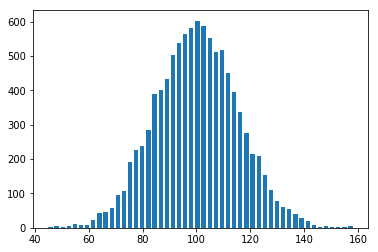

In [106]:
mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)
hist, bins = np.histogram(x, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [107]:
hist.shape

(50,)

In [109]:
bins.shape

(51,)

In [110]:
bins

array([  44.64979132,   46.92287984,   49.19596836,   51.46905689,
         53.74214541,   56.01523393,   58.28832246,   60.56141098,
         62.8344995 ,   65.10758803,   67.38067655,   69.65376507,
         71.9268536 ,   74.19994212,   76.47303064,   78.74611917,
         81.01920769,   83.29229622,   85.56538474,   87.83847326,
         90.11156179,   92.38465031,   94.65773883,   96.93082736,
         99.20391588,  101.4770044 ,  103.75009293,  106.02318145,
        108.29626997,  110.5693585 ,  112.84244702,  115.11553554,
        117.38862407,  119.66171259,  121.93480112,  124.20788964,
        126.48097816,  128.75406669,  131.02715521,  133.30024373,
        135.57333226,  137.84642078,  140.1195093 ,  142.39259783,
        144.66568635,  146.93877487,  149.2118634 ,  151.48495192,
        153.75804044,  156.03112897,  158.30421749])

In [111]:
hist

array([  3,   5,   1,   4,  10,   8,   8,  24,  44,  46,  58,  96, 108,
       193, 227, 238, 285, 391, 401, 432, 504, 538, 565, 581, 603, 588,
       553, 513, 517, 450, 396, 336, 276, 215, 210, 155, 111,  78,  61,
        54,  41,  29,  19,   8,   3,   6,   2,   1,   1,   4])